In [1]:
import redback
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from redback.simulate_transients import SimulateGenericTransient

No module named 'lalsimulation'
lalsimulation is not installed. Some EOS based models will not work. Please use bilby eos or pass your own EOS generation class to the model


In [2]:
#tophat + two component
def combined_signal(time, redshift, av, bands, num_points, noise, thv, loge0, thc, logn0, p, logepse, logepsb, ksin, g0, mej1, mej2,
                   vej1, vej2, kappa1, kappa2, temp_floor1, temp_floor2 ):
    """
    Function to combine afterglow and kilonova model flux densities
    Time specified is max time
    """
    frequency = np.array(redback.utils.bands_to_frequency(bands))
    times= np.linspace(0.01,time,100)
    
    model_kwargs = {'output_format':'flux_density', 'frequency':frequency}
    
    afterglow_params={}
    afterglow_params['base_model']= 'tophat'
    afterglow_params['redshift'] = redshift
    afterglow_params['av'] = av
    afterglow_params['loge0'] = loge0
    afterglow_params['logn0'] = logn0 
    afterglow_params['p'] = p
    afterglow_params['logepse'] = logepse
    afterglow_params['logepsb'] = logepsb
    afterglow_params['ksin'] = ksin
    afterglow_params['g0'] = g0
    afterglow_params['thv']= thv
    afterglow_params['thc'] = thc
    
    kilonova_params={}
    kilonova_params['base_model']= 'two_component_kilonova_model'
    kilonova_params['redshift'] = redshift
    kilonova_params['av']= av
    kilonova_params['mej_1'] = mej1
    kilonova_params['temperature_floor_1'] = temp_floor1 #min temp of expanding photosphere
    kilonova_params['kappa_1'] = kappa1 
    kilonova_params['vej_1'] = vej1
    kilonova_params['mej_2'] = mej2 
    kilonova_params['temperature_floor_2'] = temp_floor2 
    kilonova_params['kappa_2'] = kappa2
    kilonova_params['vej_2'] = vej2
    
    afterglow_obs= SimulateGenericTransient(model='extinction_with_afterglow_base_model', parameters=afterglow_params,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs, 
                                            multiwavelength_transient=True, noise_term=noise)

    kn_obs= SimulateGenericTransient(model='extinction_with_kilonova_base_model', parameters=kilonova_params,times=times, 
                                     data_points=num_points, model_kwargs=model_kwargs, multiwavelength_transient=True,
                                     noise_term=noise)
    
    merged_data = pd.concat([afterglow_obs.data, kn_obs.data],ignore_index=True)
    print(merged_data)
    
    transient = redback.transient.Transient(name='my_transient', flux_density=merged_data['output'].values,
                                      time=merged_data['time'].values, data_mode='flux_density',
                                      flux_density_err=merged_data['output_error'].values, frequency=merged_data['frequency'].values)
    return transient


In [27]:
print(transient.default_filters)

['g', 'r', 'i', 'z', 'y', 'J', 'H', 'K']


         time     frequency   true_output        output  output_error
0    1.524848  3.087381e+14  1.591666e-14  1.486341e-14  7.958331e-16
1    1.524848  3.972879e+14  1.153124e-14  1.218486e-14  5.765619e-16
2    2.029798  6.210931e+14  3.510461e-14  3.689654e-14  1.755230e-15
3    3.544646  3.087381e+14  3.829549e-12  3.604792e-12  1.914775e-13
4    3.544646  3.087381e+14  3.829549e-12  3.815180e-12  1.914775e-13
..        ...           ...           ...           ...           ...
95  48.485152  3.972879e+14  2.918841e-04  2.909826e-04  1.459420e-05
96  48.485152  6.210931e+14  2.915100e-06  2.998307e-06  1.457550e-07
97  48.485152  3.087381e+14  1.426075e-03  1.485635e-03  7.130376e-05
98  49.495051  3.449498e+14  7.697674e-04  8.201013e-04  3.848837e-05
99  49.495051  3.087381e+14  1.434682e-03  1.363127e-03  7.173410e-05

[100 rows x 5 columns]


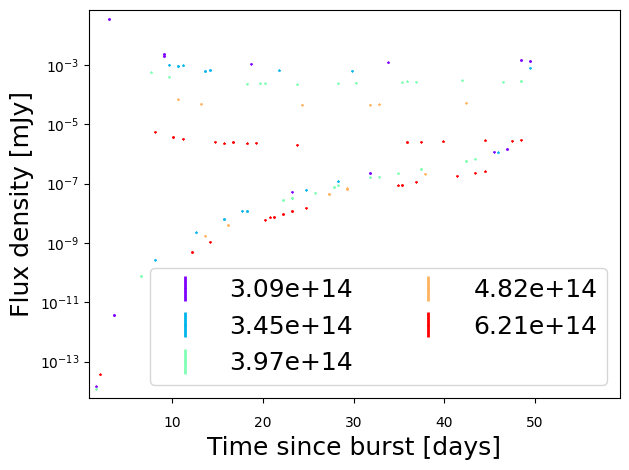

<Axes: xlabel='Time since burst [days]', ylabel='Flux density [mJy]'>

In [36]:
bands = ['lsstg', 'lsstr', 'lssti','lsstz','lssty']
transient= combined_signal(50, 0.01, 1, bands, 50, 0.05, 0.5, 52.5, 0.01, -2, 2.1, -1, -1, 0.4, 1000.0, 0.015, 0.01,
                           0.1, 0.2, 1.0, 25.0, 2000, 2000)

transient.plot_data(filters=transient.unique_frequencies)
